In [1]:
import mne
import argparse
from joblib import Parallel, delayed
import os
import logging
import numpy as np
HOMEDIR = "/users/local/Venkatesh/LSD_project"
def create_source_space(subjects_dir, subject, drug):
    """Create the source space."""
    
    subjects_dir = f"{subjects_dir}/anat/{drug}"
    

    print(f"Creating source space for subject {subject}...")
    src = mne.setup_source_space(subject, spacing='ico5', subjects_dir=subjects_dir, n_jobs=-1)
    return src

def bem(subjects_dir, subject, drug):
    """Create or load the BEM solution."""
    bem_file = f"{subjects_dir}/anat/{drug}/{subject}/bem/{subject}-bem-sol.fif"
    subjects_dir = f"{subjects_dir}/anat/{drug}"
    

    model = mne.make_bem_model(subject=subject, ico=5, conductivity=(0.3,), subjects_dir=subjects_dir)
    bem_sol = mne.make_bem_solution(model)
        
    return bem_sol

def forward_model(subjects_dir, subject, epochs, trans, src, bem_sol, drug):
    """Create or load the forward model."""
    subjects_dir = f"{subjects_dir}/anat/{drug}"


    fwd = mne.make_forward_solution(epochs.info, trans=trans, src=src, bem=bem_sol,
                                    meg=True, eeg=False,mindist=5.0)
    return fwd

def parcellation(stc):
    """Parcellate the source estimate."""
    labels=mne.read_labels_from_annot('fsaverage', 'HCPMMP1', sort=False, subjects_dir='/users/local/Venkatesh/LSD_project/src_data/derivatives/anat/LSD')
    src = mne.read_source_spaces(f"{subjects_dir}/anat/LSD/fsaverage/bem/fsaverage-ico-5-src.fif")

    exclude_indices = [0, 181]
    valid_labels = [label for i, label in enumerate(labels) if i not in exclude_indices]
    
    label_ts = mne.extract_label_time_course(
        stc, labels=valid_labels, src=src, mode="mean", allow_empty=True, mri_resolution=False
    )
    return label_ts



In [8]:
subject = "003"
drug = "LSD"
task = "Music"
subjects_dir = '/users/local/Venkatesh/LSD_project/src_data/derivatives/'

subject = f"sub-{subject}"
trans_file = f"{subjects_dir}/anat/{drug}/{subject}/bem/{subject}_trans.fif"
trans = mne.read_trans(trans_file)
epochs_file = f"{subjects_dir}/func/{task}/{drug}/{subject}/meg/{subject}_cleaned_epochs_meg.fif"

epochs = mne.read_epochs(epochs_file, preload=True)
epochs = epochs.pick_types(meg=True, eeg=False, ref_meg=False)

if not os.path.exists(f"{subjects_dir}/func/{task}/{drug}/{subject}/meg/{subject}_cleaned_epochs_resampled_meg.fif"):
    epochs = epochs.resample(250)
    epochs.save(f"{subjects_dir}/func/{task}/{drug}/{subject}/meg/{subject}_cleaned_epochs_resampled_meg.fif", overwrite=True)

else:
    epochs = mne.read_epochs(f"{subjects_dir}/func/{task}/{drug}/{subject}/meg/{subject}_cleaned_epochs_resampled_meg.fif", preload=True)
    
# Create the source space
src = create_source_space(subjects_dir, subject, drug)

# Create or load the BEM solution
bem_sol = bem(subjects_dir, subject, drug)

# # Create or load the forward model
fwd_model = forward_model(subjects_dir, subject, epochs, trans, src, bem_sol, drug)

#Compute the noise covariance matrix
noise_cov_data = np.eye(epochs.info['nchan']) 
noise_cov = mne.Covariance(data=noise_cov_data, names=epochs.info['ch_names'], bads=[], projs=[], nfree=1)

# Create the inverse operator
inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd_model, noise_cov, loose=0.2, depth=0.8)
print(f"Inverse operator created for subject {subject}.")

# # Apply the inverse solution to create a source estimate
method = "dSPM"  # could choose MNE, sLORETA, or eLORETA instead
snr = 1.0 # or 1 
lambda2 = 1.0 / snr**2
stcs = mne.minimum_norm.apply_inverse_epochs(epochs, inverse_operator, lambda2,
                                          method=method)

# source_psd = mne.minimum_norm.compute_source_psd_epochs(epochs[:2], inverse_operator, lambda2=lambda2, method=method, fmin=1.0, fmax=60.0, pick_ori=None, label=None, nave=1, pca=True, inv_split=None, adaptive=False, low_bias=True, return_generator=False, n_jobs=None, prepared=False, method_params=None, return_sensor=False, use_cps=True, verbose=None)

Reading /users/local/Venkatesh/LSD_project/src_data/derivatives/func/Music/LSD/sub-003/meg/sub-003_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1746316/2614222145.py:11: RuntimeWarning: This filename (/users/local/Venkatesh/LSD_project/src_data/derivatives//func/Music/LSD/sub-003/meg/sub-003_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_file, preload=True)


    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        5 CTF compensation matrices available
Not setting metadata
122 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
Reading /users/local/Venkatesh/LSD_project/src_data/derivatives/func/Music/LSD/sub-003/meg/sub-003_cleaned_epochs_resampled_meg.fif ...
    Found the data of interest:
        t =       0.00 ...    1998.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_1746316/2614222145.py:19: RuntimeWarning: This filename (/users/local/Venkatesh/LSD_project/src_data/derivatives//func/Music/LSD/sub-003/meg/sub-003_cleaned_epochs_resampled_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f"{subjects_dir}/func/{task}/{drug}/{subject}/meg/{subject}_cleaned_epochs_resampled_meg.fif", preload=True)


Not setting metadata
122 matching events found
No baseline correction applied
0 projection items activated
Creating source space for subject sub-003...
Setting up the source space with the following parameters:

SUBJECTS_DIR = /users/local/Venkatesh/LSD_project/src_data/derivatives/anat/LSD
Subject      = sub-003
Surface      = white
Icosahedron subdivision grade 5

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /users/local/Venkatesh/LSD_project/src_data/derivatives/anat/LSD/sub-003/surf/lh.white...
Mapping lh sub-003 -> ico (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from /users/local/Venkatesh/LSD_project/src_data/derivatives/anat/LSD/sub-003/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 10242/140321 selected to source space (ico = 5)

Loading /users/local/Venkatesh/LSD_project/src_data/derivatives/anat/LSD/sub-003/surf/rh.white...
Mapping rh sub-003 -> ico (5) ...
    Trian

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  48 | elapsed:   36.0s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  21 out of  48 | elapsed:   45.7s remaining:   58.8s
[Parallel(n_jobs=-1)]: Done  31 out of  48 | elapsed:   46.3s remaining:   25.4s
[Parallel(n_jobs=-1)]: Done  41 out of  48 | elapsed:   47.6s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   49.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  48 | elapsed:   33.5s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  21 out of  48 | elapsed:   36.7s remaining:   47.2s
[Parallel(n_jobs=-1)]: Done  31 out of  48 | elapsed:   39.1s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done  41 out of  48 | elapsed:   39.9s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   41.6s finished


    Computing patch statistics...
    Patch information added...
    Computing patch statistics...
    Patch information added...
You are now one step closer to computing the gain matrix
Creating the BEM geometry...
Going from 5th to 5th subdivision of an icosahedron (n_tri: 20480 -> 20480)
inner skull CM is  -4.02 -15.17  -6.10 mm
Surfaces passed the basic topology checks.
Complete.

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (10242) -> inner skull (10242) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.
Source space          : <SourceSpaces: [<surface (lh), n_vertices=140321, n_used=10242>, <surface (rh), n_vertices=138252, n_used=10242>] MRI (surface RAS) coords, subject 'sub-003', ~31.8 MB>
MRI -> head transform : instance of Transform
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do c

In [9]:
stcs[0].data.shape

(20484, 1000)

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).


/tmp/ipykernel_1746316/635856766.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  source_epochs.compute_psd(fmin=1, fmax=60).plot()
/users/local/Venkatesh/LSD_project/LSD_environment/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


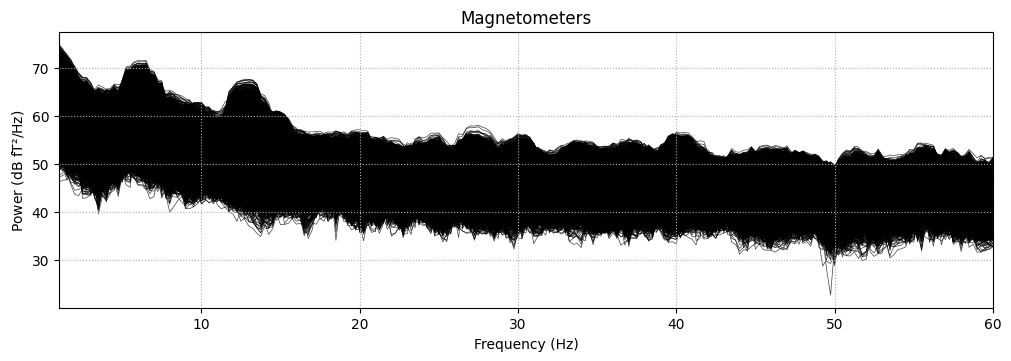

In [10]:
ch_array = [f"ch {i}" for i in range(20484)]

info = mne.create_info(ch_names=ch_array, sfreq=250, ch_types='mag')

source_epochs= mne.EpochsArray(stcs[0].data.reshape(1, stcs[0].data.shape[0], stcs[0].data.shape[1]), info)
source_epochs.compute_psd(fmin=1, fmax=60).plot()

In [16]:
source_epochs.compute_psd(fmin=1, fmax=60).data

    Using multitaper spectrum estimation with 7 DPSS windows


array([[[1.95997834e-25, 1.94043940e-25, 8.18094681e-26, ...,
         5.75233375e-27, 4.85610211e-27, 4.43996369e-27],
        [2.42768223e-25, 2.19987668e-25, 6.46963904e-26, ...,
         6.73266880e-27, 6.08579491e-27, 6.09155233e-27],
        [2.26205762e-25, 2.21656354e-25, 6.48726129e-26, ...,
         4.65198765e-27, 3.87820815e-27, 3.75665530e-27],
        ...,
        [3.35070544e-25, 2.40082093e-25, 2.39504297e-25, ...,
         3.97104384e-27, 2.98474345e-27, 2.51910030e-27],
        [9.41449149e-25, 1.58073192e-24, 1.27840643e-24, ...,
         3.74828910e-26, 2.95493541e-26, 2.78626783e-26],
        [2.43504716e-24, 2.57898447e-24, 2.14819504e-24, ...,
         2.60232939e-26, 2.29781239e-26, 2.07799482e-26]]])

In [5]:
label_path = "/users/local/Venkatesh/LSD_project/src_data/derivatives/anat/LSD/fsaverage/label/rh.V1.label"
label = mne.read_label(label_path)
source_psd = mne.minimum_norm.compute_source_psd_epochs(epochs[:2], inverse_operator, lambda2=lambda2, method=method, fmin=1.0, fmax=60.0, pick_ori=None, label=label, nave=1, pca=True, inv_split=None, adaptive=False, low_bias=True, return_generator=False, n_jobs=None, prepared=False, method_params=None, return_sensor=True, use_cps=True, verbose=None)

Considering frequencies 1.0 ... 60.0 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 271 (0 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 271 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 271 -> 270
Using 7 tapers with bandwidth 4.0 Hz on 2 epochs


/users/local/Venkatesh/LSD_project/LSD_environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████|  : 2/2 [00:02<00:00,    1.43s/it]


In [6]:
plt.plot(source_psd[0][1].get_data().T)

NameError: name 'plt' is not defined

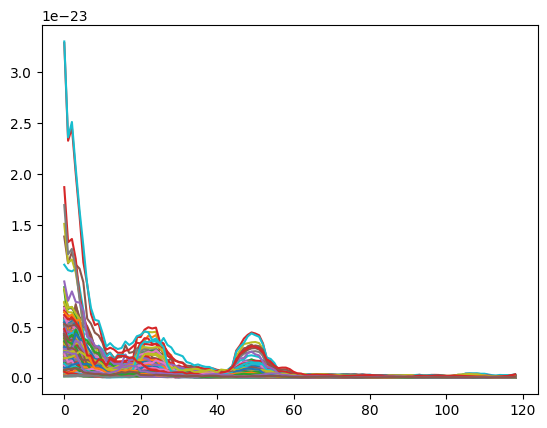

In [106]:
plt.plot(source_psd[0][0].data.T)


In [19]:
from mne.datasets import sample
data_path = sample.data_path()
raw_fname = data_path / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"


In [25]:

raw = mne.io.read_raw_fif(raw_fname)  # already has an average reference
events = mne.find_events(raw, stim_channel="STI 014")

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info["bads"] = ["MEG 2443", "EEG 053"]  # mark known bad channels
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=("meg", "eog"),
    baseline=baseline,
    reject=reject,
)

Opening raw data file /homes/v20subra/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated


In [37]:

# # Create the source space
# src = create_source_space(subjects_dir, subject, drug)

# # Create or load the BEM solution
# bem_sol = bem(subjects_dir, subject, drug)

# # # Create or load the forward model
# fwd_model = forward_model(subjects_dir, subject, epochs, None, src, bem_sol, drug)

# #Compute the noise covariance matrix
# noise_cov_data = np.eye(epochs.info['nchan']) 
# noise_cov = mne.Covariance(data=noise_cov_data, names=epochs.info['ch_names'], bads=[], projs=[], nfree=1)

# # Create the inverse operator
# inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd_model, noise_cov, loose=0.2, depth=0.8)
# print(f"Inverse operator created for subject {subject}.")

# # # Apply the inverse solution to create a source estimate
method = "dSPM"  # could choose MNE, sLORETA, or eLORETA instead
snr = 3.0 # or 1 
lambda2 = 1.0 / snr**2
evoked = epochs.average()
# stcs = mne.minimum_norm.apply_inverse(evoked, inverse_operator, lambda2,
#                                           method=method)`
stc, residual = mne.minimum_norm.apply_inverse(
    evoked,
    inverse_operator,
    lambda2,
    method=method,
    pick_ori=None,
    return_residual=True,
    verbose=True,
)

# source_psd = mne.minimum_norm.compute_source_psd_epochs(epochs[:2], inverse_operator, lambda2=lambda2, method=method, fmin=1.0, fmax=60.0, pick_ori=None, label=None, nave=1, pca=True, inv_split=None, adaptive=False, low_bias=True, return_generator=False, n_jobs=None, prepared=False, method_params=None, return_sensor=False, use_cps=True, verbose=None)

    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']


    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normaliz

In [28]:
stcs.data

AttributeError: 'list' object has no attribute 'data'

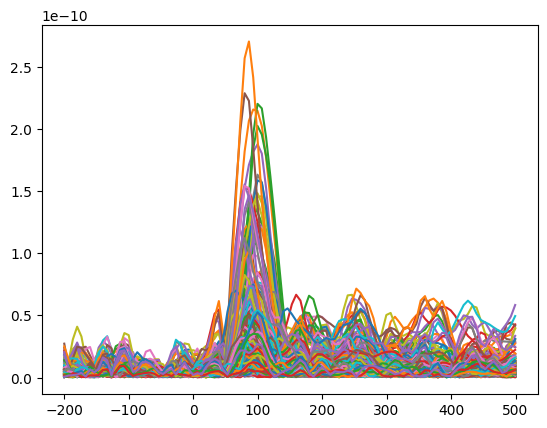

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(1e3 * stc.times, stc.data[::100, :].T)
# ax.set(xlabel="time (ms)", ylabel=f"{method} value")

plt.show()

Octahedron subdivision grade 6


    Triangle neighbors and vertex normals...
Loading geometry from /users/local/Venkatesh/LSD_project/src_data/derivatives/anat/LSD/sub-003/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


/tmp/ipykernel_1746316/2373160667.py:14: RuntimeWarning: 11/138252 vertices not included in smoothing, consider increasing the number of steps
  brain = stc.plot(**surfer_kwargs, backend='matplotlib')


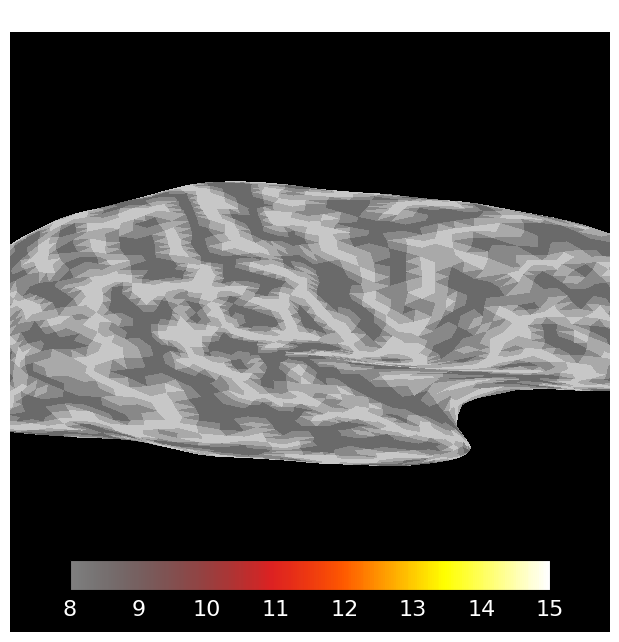

AttributeError: 'Figure' object has no attribute 'add_foci'

In [50]:
vertno_max, time_max = stc.get_peak(hemi="rh")

subjects_dir = "/users/local/Venkatesh/LSD_project/src_data/derivatives/anat/LSD"
surfer_kwargs = dict(
    hemi="rh",
    subjects_dir=subjects_dir,
    clim=dict(kind="value", lims=[8, 12, 15]),
    
    initial_time=time_max,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=10,
)
brain = stc.plot(**surfer_kwargs, backend='matplotlib')
brain.add_foci(
    vertno_max,
    coords_as_verts=True,
    hemi="rh",
    color="blue",
    scale_factor=0.6,
    alpha=0.5,
)
brain.add_text(
    0.1, 0.9, "dSPM (plus location of maximal activation)", "title", font_size=14
)

# The documentation website's movie is generated with:
# brain.save_movie(..., tmin=0.05, tmax=0.15, interpolation='linear',
#                  time_dilation=20, framerate=10, time_viewer=True)

Opening raw data file /homes/v20subra/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 72 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epo

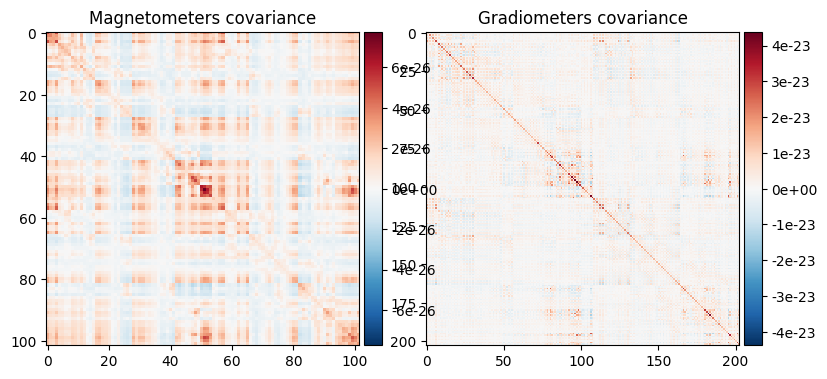

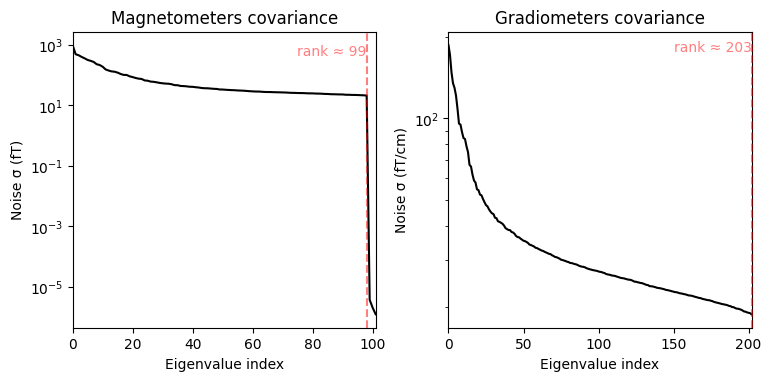

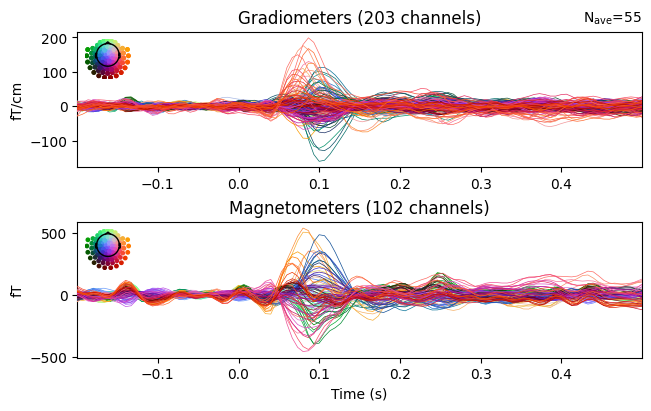

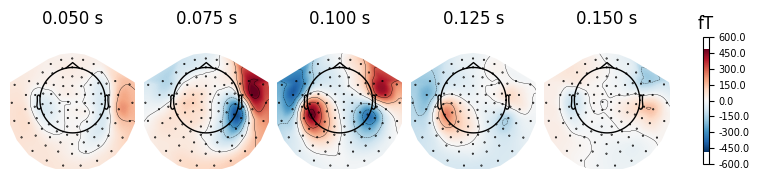

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 1.6e-13 (2.2e-16 eps * 203 dim * 3.5  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.2e-14 (2.2e-16 eps * 102 dim * 0.98  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 3 projectors
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank={'grad': 203, 'mag': 99, 'meg': 302}
    Setting small MEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)


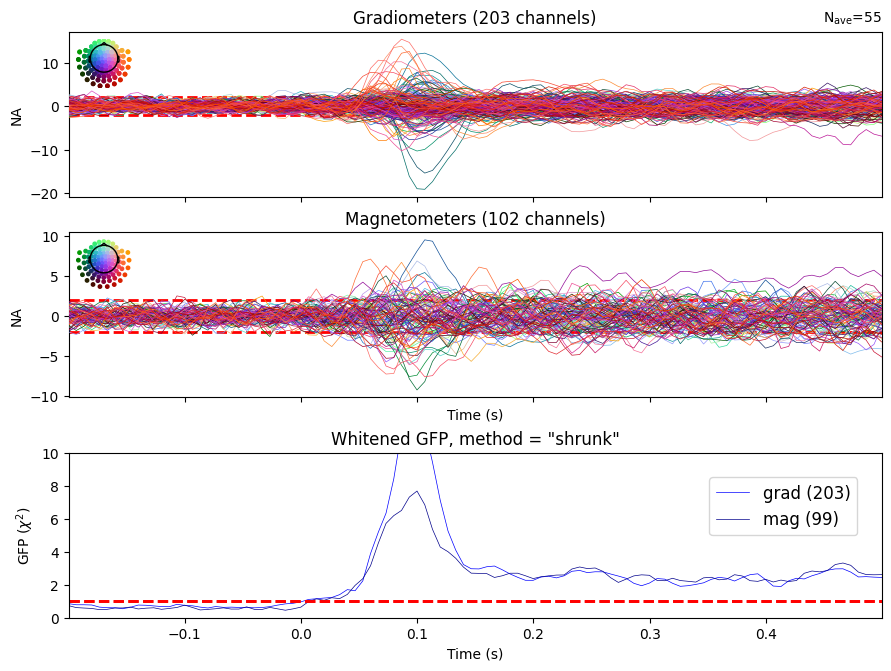

Reading forward solution from /homes/v20subra/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 305 channels.
  

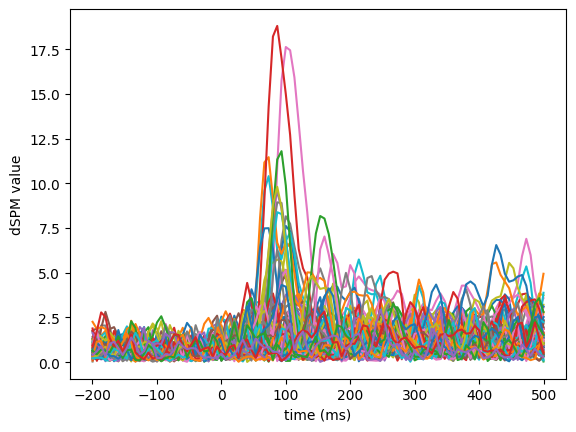

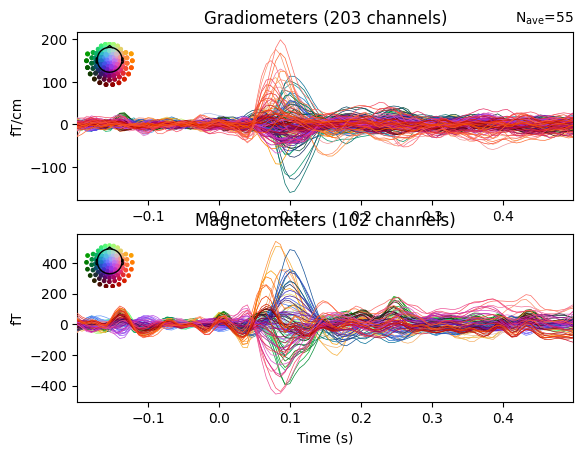

RuntimeError: Cannot connect to a valid display

In [52]:
"""
.. _tut-inverse-methods:

========================================================
Source localization with MNE, dSPM, sLORETA, and eLORETA
========================================================

The aim of this tutorial is to teach you how to compute and apply a linear
minimum-norm inverse method on evoked/raw/epochs data.
"""

# Authors: The MNE-Python contributors.
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

# %%

import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse, make_inverse_operator

# %%
# Process MEG data

data_path = sample.data_path()
raw_fname = data_path / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"

raw = mne.io.read_raw_fif(raw_fname)  # already has an average reference
events = mne.find_events(raw, stim_channel="STI 014")

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info["bads"] = ["MEG 2443", "EEG 053"]  # mark known bad channels
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=("meg", "eog"),
    baseline=baseline,
    reject=reject,
)

# %%
# Compute regularized noise covariance
# ------------------------------------
# For more details see :ref:`tut-compute-covariance`.

noise_cov = mne.compute_covariance(
    epochs, tmax=0.0, method=["shrunk", "empirical"], rank=None, verbose=True
)

fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)

# %%
# Compute the evoked response
# ---------------------------
# Let's just use the MEG channels for simplicity.

evoked = epochs.average().pick("meg")
evoked.plot(time_unit="s")
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type="mag")

# %%
# It's also a good idea to look at whitened data:

evoked.plot_white(noise_cov, time_unit="s")
del epochs, raw  # to save memory

# %%
# Inverse modeling: MNE/dSPM on evoked and raw data
# -------------------------------------------------
# Here we first read the forward solution. You will likely need to compute
# one for your own data -- see :ref:`tut-forward` for information on how
# to do it.

fname_fwd = data_path / "MEG" / "sample" / "sample_audvis-meg-oct-6-fwd.fif"
fwd = mne.read_forward_solution(fname_fwd)

# %%
# Next, we make an MEG inverse operator.

inverse_operator = make_inverse_operator(
    evoked.info, fwd, noise_cov, loose=0.2, depth=0.8
)
del fwd

# %%
# .. note::
#
#     You can write the inverse operator to disk with:
#
#     .. code-block::
#
#         from mne.minimum_norm import write_inverse_operator
#         write_inverse_operator(
#             "sample_audvis-meg-oct-6-inv.fif", inverse_operator
#         )
#
# Compute inverse solution
# ------------------------
# We can use this to compute the inverse solution and obtain source time
# courses:

method = "dSPM"  # could choose MNE, sLORETA, or eLORETA instead
snr = 3.0
lambda2 = 1.0 / snr**2
stc, residual = apply_inverse(
    evoked,
    inverse_operator,
    lambda2,
    method=method,
    pick_ori=None,
    return_residual=True,
    verbose=True,
)

# %%
# Visualization
# -------------
# We can look at different dipole activations:

fig, ax = plt.subplots()
ax.plot(1e3 * stc.times, stc.data[::100, :].T)
ax.set(xlabel="time (ms)", ylabel=f"{method} value")

# %%
# Examine the original data and the residual after fitting:

fig, axes = plt.subplots(2, 1)
evoked.plot(axes=axes)
for ax in axes:
    for text in list(ax.texts):
        text.remove()
    for line in ax.lines:
        line.set_color("#98df81")
residual.plot(axes=axes)

# %%
# Here we use peak getter to move visualization to the time point of the peak
# and draw a marker at the maximum peak vertex.

# sphinx_gallery_thumbnail_number = 9

vertno_max, time_max = stc.get_peak(hemi="rh")

subjects_dir = data_path / "subjects"
surfer_kwargs = dict(
    hemi="rh",
    subjects_dir=subjects_dir,
    clim=dict(kind="value", lims=[8, 12, 15]),
    views="lateral",
    initial_time=time_max,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=10,
)
brain = stc.plot(**surfer_kwargs)
brain.add_foci(
    vertno_max,
    coords_as_verts=True,
    hemi="rh",
    color="blue",
    scale_factor=0.6,
    alpha=0.5,
)
brain.add_text(
    0.1, 0.9, "dSPM (plus location of maximal activation)", "title", font_size=14
)

# The documentation website's movie is generated with:
# brain.save_movie(..., tmin=0.05, tmax=0.15, interpolation='linear',
#                  time_dilation=20, framerate=10, time_viewer=True)

# %%
# There are many other ways to visualize and work with source data, see
# for example:
#
# - :ref:`tut-viz-stcs`
# - :ref:`ex-morph-surface`
# - :ref:`ex-morph-volume`
# - :ref:`ex-vector-mne-solution`
# - :ref:`tut-dipole-orientations`
# - :ref:`tut-mne-fixed-free`
# - :ref:`examples using apply_inverse
#   <sphx_glr_backreferences_mne.minimum_norm.apply_inverse>`.


In [53]:
vertno_max

np.int64(73919)

In [3]:
import numpy as np
stc= np.load('/users/local/Venkatesh/LSD_project/src_data/derivatives/func/Music/LSD/sub-005/meg/source_estimates/sub-005_source_estimate_parcellated.npz')['stc_parcellated']

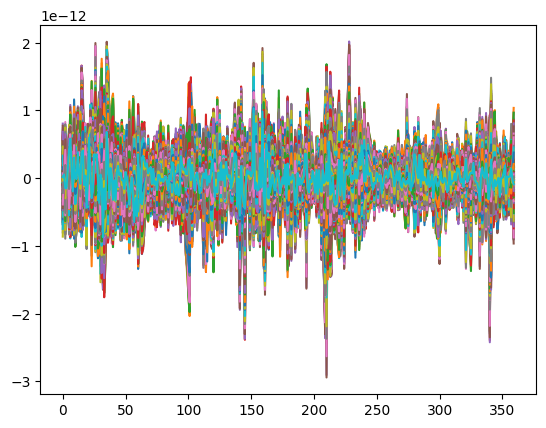

In [7]:
import matplotlib.pyplot as plt
plt.plot(stc[0])[0]